This Jupyter notebook uses the Sprague multipliers' methodology outlined in the paper "Reconstructing school-age populations by estimating population by single years of age for different polygons from raster data" for the Colombian Census of 2018. It uses raster data from WorldPop (https://www.worldpop.org/geodata/summary?id=16325), and the information on the Census was obtained from the National Bureau of Statistics of Colombia - DANE (http://microdatos.dane.gov.co/index.php/catalog/643/data_dictionary), from the 2018 National Census, for all 1118 municipalities. 

The information on the starting age and duration of each educational level, used for the reconstruction of the educational level populations for both census and projection data was obtained from data.uis.unesco.org, and is shown below:

The information on the starting age and duration of each educational level, used for the reconstruction of the educational level populations for both census and projection data was obtained from data.uis.unesco.org, and is shown below:

In [1]:
import pandas as pd
EducationSystem = {"Educational level": ["ECE", "Pre-primary", "Primary", "Lower secondary", "Upper secondary"], "Starting age": ["N/A","3","6","11","15"], "Duration":["6","3","5","4","2"]}
EducationSystem = pd.DataFrame(EducationSystem)  
print(EducationSystem)

  Educational level Starting age Duration
0               ECE          N/A        6
1       Pre-primary            3        3
2           Primary            6        5
3   Lower secondary           11        4
4   Upper secondary           15        2


In [2]:
import sys, os, csv, math, statsmodels
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.diagnostic as diag
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera
%matplotlib inline
%config InlineBackend.figure_format='retina'

The user is prompted to insert the appropriate working directory

In [3]:
os.chdir("C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\\MP_01000298_RND_SDA\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data")  # REMOVE
if os.getcwd()!="C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\\MP_01000298_RND_SDA\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data":
    print("Please insert the WORKING DIRECTORY")                                                            # We create a loop so that the user establishes the working directory
    print("Remember to separate the backslash (for Windows) or forward slash (in Mac)") 
    while True:                                                                             
        NewPath=input()                                                                                     # The user inserts the working directory
        if os.path.exists(NewPath)==True:                                                                   # If the program exists, the working directory will be updated
            os.chdir(NewPath)                                                               
            print("Your new path is " + os.getcwd())                                        
            break                                                                                           # If the condition is met, the program keeps running
        else:                                                                                               # If the condition is not met, the program requests the user to
            print("Please check if the path is correctly written")                                          # insert a new path and the condition is checked again
        continue
else: 
    print("Your path is " + os.getcwd())

Please insert the WORKING DIRECTORY
Remember to separate the backslash (for Windows) or forward slash (in Mac)
C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\\MP_01000298_RND_SDA\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data
Your new path is C:\Users\g.vargas\BOX\IIEP_MyProjects\MP_01000298_RND_SDA\WorkFiles_Experts\298-Issue-Papers\298-Issue-Paper-Sprague\Replication files\Data


We import the raw data from the 2018 Census, were we keep only 2018 data, and we rename the variables for ease of use

In [4]:
Colombia = pd.read_excel('Tables\\Colombia\\anexo-proyecciones-poblacion-Municipal_2018-2026.xlsx', sheet_name='Municipal_2018_2026', skiprows=11)

In [5]:
Colombia = Colombia[Colombia['ÁREA GEOGRÁFICA']=='Total']
Colombia = Colombia[Colombia['AÑO']==2018]
del Colombia['AÑO']
del Colombia['ÁREA GEOGRÁFICA']
Colombia

,DP,DPNOM,DPMP,MPIO,Hombres_0,Hombres_1,Hombres_2,Hombres_3,Hombres_4,Hombres_5,...,Total_94,Total_95,Total_96,Total_97,Total_98,Total_99,Total_100 y más,Total Hombres,Total Mujeres,Total
2,5,Antioquia,5001,Medellín,14474,14600,14699,14782,14861,14942,...,936,783,627,566,495,482,1544,1140658,1286471,2427129
29,5,Antioquia,5002,Abejorral,132,130,129,132,136,141,...,6,7,7,4,5,9,15,10534,9833,20367
56,5,Antioquia,5004,Abriaquí,24,23,23,24,22,23,...,0,0,0,0,3,1,0,1452,1243,2695
83,5,Antioquia,5021,Alejandría,43,43,43,42,42,42,...,1,1,1,0,3,1,0,2320,2337,4657
110,5,Antioquia,5030,Amagá,204,202,203,203,204,204,...,13,6,5,4,5,9,9,14862,15365,30227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30161,97,Vaupés,97889,Yavaraté (CD),9,9,8,9,9,19,...,1,0,1,0,0,1,0,546,502,1048
30188,99,Vichada,99001,Puerto Carreño,231,232,230,230,229,226,...,2,2,2,1,2,3,4,11024,9912,20936
30215,99,Vichada,99524,La Primavera,111,112,110,112,108,111,...,2,2,1,0,0,6,2,5398,4724,10122
30242,99,Vichada,99624,Santa Rosalía,37,37,37,37,38,41,...,2,1,0,0,0,0,0,2130,1929,4059


In [6]:
Colombia = Colombia[['DP', 'DPNOM', 'DPMP', 'MPIO', 'Hombres_0', 'Hombres_1', 'Hombres_2', 'Hombres_3', 'Hombres_4', 'Hombres_5', 'Hombres_6', 'Hombres_7', 'Hombres_8', 'Hombres_9', 'Hombres_10', 'Hombres_11', 'Hombres_12', 'Hombres_13', 'Hombres_14', 'Hombres_15', 'Hombres_16', 'Hombres_17', 'Hombres_18', 'Hombres_19', 'Hombres_20', 'Hombres_21', 'Hombres_22', 'Hombres_23', 'Hombres_24', 'Hombres_25', 'Hombres_26', 'Hombres_27', 'Hombres_28', 'Hombres_29', 'Hombres_30', 'Hombres_31', 'Hombres_32', 'Hombres_33', 'Hombres_34', 'Hombres_35', 'Hombres_36', 'Hombres_37', 'Hombres_38', 'Hombres_39', 'Mujeres_0', 'Mujeres_1', 'Mujeres_2', 'Mujeres_3', 'Mujeres_4', 'Mujeres_5', 'Mujeres_6', 'Mujeres_7', 'Mujeres_8', 'Mujeres_9', 'Mujeres_10', 'Mujeres_11', 'Mujeres_12', 'Mujeres_13', 'Mujeres_14', 'Mujeres_15', 'Mujeres_16', 'Mujeres_17', 'Mujeres_18', 'Mujeres_19', 'Mujeres_20', 'Mujeres_21', 'Mujeres_22', 'Mujeres_23', 'Mujeres_24', 'Mujeres_25', 'Mujeres_26', 'Mujeres_27', 'Mujeres_28', 'Mujeres_29', 'Mujeres_30', 'Mujeres_31', 'Mujeres_32', 'Mujeres_33', 'Mujeres_34', 'Mujeres_35', 'Mujeres_36', 'Mujeres_37', 'Mujeres_38', 'Mujeres_39']]

In [7]:
Colombia.to_csv('Tables\\Colombia\\Population_Colombia_clean.csv', index=False, header=["DpCode", "DpName", "admin2Pcod", "MunName", "Male_0", "Male_1", "Male_2", "Male_3", "Male_4", "Male_5", "Male_6", "Male_7", "Male_8", "Male_9", "Male_10", "Male_11", "Male_12", "Male_13", "Male_14", "Male_15", "Male_16", "Male_17", "Male_18", "Male_19", "Male_20", "Male_21", "Male_22", "Male_23", "Male_24", "Male_25", "Male_26", "Male_27", "Male_28", "Male_29", "Male_30", "Male_31", "Male_32", "Male_33", "Male_34", "Male_35", "Male_36", "Male_37", "Male_38", "Male_39", "Female_0", "Female_1", "Female_2", "Female_3", "Female_4", "Female_5", "Female_6", "Female_7", "Female_8", "Female_9", "Female_10", "Female_11", "Female_12", "Female_13", "Female_14", "Female_15", "Female_16", "Female_17", "Female_18", "Female_19", "Female_20", "Female_21", "Female_22", "Female_23", "Female_24", "Female_25", "Female_26", "Female_27", "Female_28", "Female_29", "Female_30", "Female_31", "Female_32", "Female_33", "Female_34", "Female_35", "Female_36", "Female_37", "Female_38", "Female_39"])

Once we eliminate the old variables, we have a clean estimation for municipality in the 2018 Census data.

## Comparing the estimated population with the actual population

### Creating the different age groups for Colombia

This information was obtained from the UNESCO Institute of Statistics (data.uis.unesco.org).

#### Census data


In [8]:
CensusData = pd.read_csv("Tables\\Colombia\\Population_Colombia_clean.csv")

CensusData['admin2Pcod'] = CensusData['admin2Pcod'].apply(int)

# ECE (Starting age: 3 years old - Duration: 3 years)
#CensusData['CD_ECE_Female'] = CensusData['Female_3'] + CensusData['Female_4'] + CensusData['Female_5'] 
#CensusData['CD_ECE_Male'] = CensusData['Male_3'] + CensusData['Male_4'] + CensusData['Male_5']
#CensusData['CD_ECE'] = CensusData['CD_ECE_Female'] + CensusData['CD_ECE_Male']

# Pre-primary (Starting age: 3 years old - Duration: 3 years)
CensusData['CD_PrePrimary_Female'] = CensusData['Female_3'] + CensusData['Female_4'] + CensusData['Female_5'] 
CensusData['CD_PrePrimary_Male'] = CensusData['Male_3'] + CensusData['Male_4'] + CensusData['Male_5']
CensusData['CD_PrePrimary'] = CensusData['CD_PrePrimary_Female'] + CensusData['CD_PrePrimary_Male']

# Primary (Starting age: 6 years old - Duration: 5 years)
CensusData['CD_Primary_Female'] = CensusData['Female_6'] + CensusData['Female_7'] + CensusData['Female_8'] + CensusData['Female_9'] + CensusData['Female_10']
CensusData['CD_Primary_Male'] = CensusData['Male_6'] + CensusData['Male_7'] + CensusData['Male_8'] + CensusData['Male_9'] + CensusData['Male_10']
CensusData['CD_Primary'] = CensusData['CD_Primary_Female'] + CensusData['CD_Primary_Male']

# Lower secondary (Starting age: 11 years old - Duration: 4 years)
CensusData['CD_LowSec_Female'] = CensusData['Female_11'] + CensusData['Female_12'] + CensusData['Female_13'] + CensusData['Female_14'] 
CensusData['CD_LowSec_Male'] = CensusData['Male_11'] + CensusData['Male_12'] + CensusData['Male_13'] + CensusData['Male_14']
CensusData['CD_LowSec'] = CensusData['CD_LowSec_Female'] + CensusData['CD_LowSec_Male']

# Upper secondary (Starting age: 15 years old - Duration: 3 years)
CensusData['CD_UppSec_Female'] = CensusData['Female_15'] + CensusData['Female_16'] 
CensusData['CD_UppSec_Male'] = CensusData['Male_15'] + CensusData['Male_16'] 
CensusData['CD_UppSec'] = CensusData['CD_UppSec_Female'] + CensusData['CD_UppSec_Male']

#### Estimated data

In [9]:
PopulationEstimates = pd.read_csv("Raster data\\Colombia\\Population_estimates_col2018SchoolAge.csv", usecols=['admin2Pcod', 'Shape_Area', 'Pre_primary_F', 'Pre_primary_M', 'Pre_primary_T', 'Primary_F', 'Primary_M', 'Primary_T', 'LowSec_F', 'LowSec_M', 'LowSec_T', 'UppSec_F', 'UppSec_M', 'UppSec_T'])
PopulationEstimates['admin2Pcod'] = PopulationEstimates['admin2Pcod'].apply(lambda x: x[-5:])
PopulationEstimates['admin2Pcod'] = pd.to_numeric(PopulationEstimates['admin2Pcod'])
PopulationEstimates = PopulationEstimates.rename(columns={'Shape_Area':'Area', 'Pre_primary_F': 'PE_PrePrimary_Female', 'Pre_primary_M': 'PE_PrePrimary_Male', 'Pre_primary_T': 'PE_PrePrimary', 'Primary_F': 'PE_Primary_Female', 'Primary_M': 'PE_Primary_Male', 'Primary_T': 'PE_Primary', 'LowSec_F': 'PE_LowSec_Female', 'LowSec_M': 'PE_LowSec_Male', 'LowSec_T': 'PE_LowSec', 'UppSec_F': 'PE_UppSec_Female', 'UppSec_M': 'PE_UppSec_Male', 'UppSec_T': 'PE_UppSec'} )

### Combining the databases

We combine the two datasets using the unique identifying code, keeping only the identifiers, the Area of the polygon, and the relevant educational level population groups by sex.

In [10]:
MergedData = pd.merge(CensusData, PopulationEstimates, how='inner', on='admin2Pcod')
MergedData = MergedData[["DpCode", "DpName", "admin2Pcod", 'MunName', 'PE_PrePrimary_Female', 'PE_PrePrimary_Male', 'PE_PrePrimary', 'PE_Primary_Female', 'PE_Primary_Male', 'PE_Primary', 'PE_LowSec_Female', 'PE_LowSec_Male', 'PE_LowSec', 'PE_UppSec_Female', 'PE_UppSec_Male', 'PE_UppSec', 'CD_PrePrimary_Female', 'CD_PrePrimary_Male', 'CD_PrePrimary', 'CD_Primary_Female', 'CD_Primary_Male', 'CD_Primary', 'CD_LowSec_Female', 'CD_LowSec_Male', 'CD_LowSec', 'CD_UppSec_Female', 'CD_UppSec_Male', 'CD_UppSec', 'Area']]
MergedData

,DpCode,DpName,admin2Pcod,MunName,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,PE_Primary_Male,PE_Primary,...,CD_Primary_Female,CD_Primary_Male,CD_Primary,CD_LowSec_Female,CD_LowSec_Male,CD_LowSec,CD_UppSec_Female,CD_UppSec_Male,CD_UppSec,Area
0,5,Antioquia,5001,Medellín,60034.652190,62523.359457,122558.011647,128654.128193,134286.522860,262940.651053,...,74458,76732,151190,65054,66591,131645,35720,36446,72166,0.030429
1,5,Antioquia,5002,Abejorral,539.229370,561.592860,1100.822231,1155.624687,1206.233050,2361.857737,...,731,780,1511,629,707,1336,320,369,689,0.041417
2,5,Antioquia,5004,Abriaquí,72.337968,75.336703,147.674671,155.020107,161.806787,316.826894,...,98,113,211,78,94,172,39,52,91,0.023615
3,5,Antioquia,5021,Alejandría,100.546837,104.714957,205.261794,215.471652,224.904861,440.376513,...,186,196,382,136,151,287,66,76,142,0.010345
4,5,Antioquia,5030,Amagá,728.612361,758.816632,1487.428992,1561.414695,1629.772422,3191.187117,...,1013,1048,2061,870,896,1766,463,479,942,0.006786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,97,Vaupés,97889,Yavaraté (CD),91.853418,92.721427,184.574845,150.451200,147.869448,298.320649,...,123,109,232,90,105,195,35,44,79,0.379748
1112,99,Vichada,99001,Puerto Carreño,784.370880,779.228297,1563.599178,1261.885498,1257.475612,2519.361110,...,1029,1100,2129,777,873,1650,380,448,828,0.988744
1113,99,Vichada,99524,La Primavera,694.197186,689.679986,1383.877172,1117.169475,1113.341354,2230.510829,...,561,601,1162,468,517,985,210,248,458,1.639548
1114,99,Vichada,99624,Santa Rosalía,118.647428,117.901273,236.548701,191.207441,190.610337,381.817778,...,254,255,509,200,208,408,90,96,186,0.162155


We create additional variables. Note that PE = Population Estimates (from WorldPop) and CD = Census Data (from the 2018 Census).

In [11]:
Levels = ['PrePrimary', 'Primary', 'LowSec', 'UppSec']

for x in range(len(Levels)):
    MergedData['Dif_'+Levels[x]] = MergedData['PE_'+Levels[x]] - MergedData['CD_'+Levels[x]]
    MergedData['Dif_'+Levels[x]+'_std'] = (MergedData['Dif_'+Levels[x]] - MergedData['Dif_'+Levels[x]].mean())/MergedData['Dif_'+Levels[x]].std()
    MergedData['PE_'+Levels[x]+'_std'] = (MergedData['PE_'+Levels[x]] - MergedData['PE_'+Levels[x]].mean())/MergedData['PE_'+Levels[x]].std()
    MergedData['CD_'+Levels[x]+'_std'] = (MergedData['CD_'+Levels[x]] - MergedData['CD_'+Levels[x]].mean())/MergedData['CD_'+Levels[x]].std()
MergedData

,DpCode,DpName,admin2Pcod,MunName,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,PE_Primary_Male,PE_Primary,...,PE_Primary_std,CD_Primary_std,Dif_LowSec,Dif_LowSec_std,PE_LowSec_std,CD_LowSec_std,Dif_UppSec,Dif_UppSec_std,PE_UppSec_std,CD_UppSec_std
0,5,Antioquia,5001,Medellín,60034.652190,62523.359457,122558.011647,128654.128193,134286.522860,262940.651053,...,9.473174,8.796612,9303.912074,8.053805,9.935554,9.130772,73153.611158,10.415423,9.912817,9.395248
1,5,Antioquia,5002,Abejorral,539.229370,561.592860,1100.822231,1155.624687,1206.233050,2361.857737,...,-0.098110,-0.114842,-69.896133,0.128473,-0.096478,-0.105991,616.357750,-0.080407,-0.092042,-0.102207
2,5,Antioquia,5004,Abriaquí,72.337968,75.336703,147.674671,155.020107,161.806787,316.826894,...,-0.173226,-0.192240,-2.165454,0.185738,-0.175212,-0.188499,84.100962,-0.157422,-0.170562,-0.181665
3,5,Antioquia,5021,Alejandría,100.546837,104.714957,205.261794,215.471652,224.904861,440.376513,...,-0.168688,-0.182059,-50.936880,0.144503,-0.170456,-0.180348,101.383225,-0.154921,-0.165819,-0.174889
4,5,Antioquia,5030,Amagá,728.612361,758.816632,1487.428992,1561.414695,1629.772422,3191.187117,...,-0.067648,-0.082097,-55.369291,0.140755,-0.064552,-0.075511,821.675829,-0.050698,-0.060202,-0.068589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,97,Vaupés,97889,Yavaraté (CD),91.853418,92.721427,184.574845,150.451200,147.869448,298.320649,...,-0.173906,-0.190990,-45.984700,0.148690,-0.176707,-0.186869,79.000857,-0.158160,-0.171750,-0.183260
1112,99,Vichada,99001,Puerto Carreño,784.370880,779.228297,1563.599178,1261.885498,1257.475612,2519.361110,...,-0.092325,-0.078048,-554.048618,-0.280866,-0.108698,-0.083734,263.339537,-0.131487,-0.106910,-0.083737
1113,99,Vichada,99524,La Primavera,694.197186,689.679986,1383.877172,1117.169475,1113.341354,2230.510829,...,-0.102935,-0.135620,-14.524995,0.175288,-0.117710,-0.130871,508.310739,-0.096040,-0.115596,-0.132900
1114,99,Vichada,99624,Santa Rosalía,118.647428,117.901273,236.548701,191.207441,190.610337,381.817778,...,-0.170839,-0.174498,-241.741272,-0.016818,-0.175469,-0.171771,-20.515605,-0.172559,-0.171230,-0.169042


We begin by creating overlapping histograms for each educational level. If the methodology works, they should generally overlap.

Pre-primary


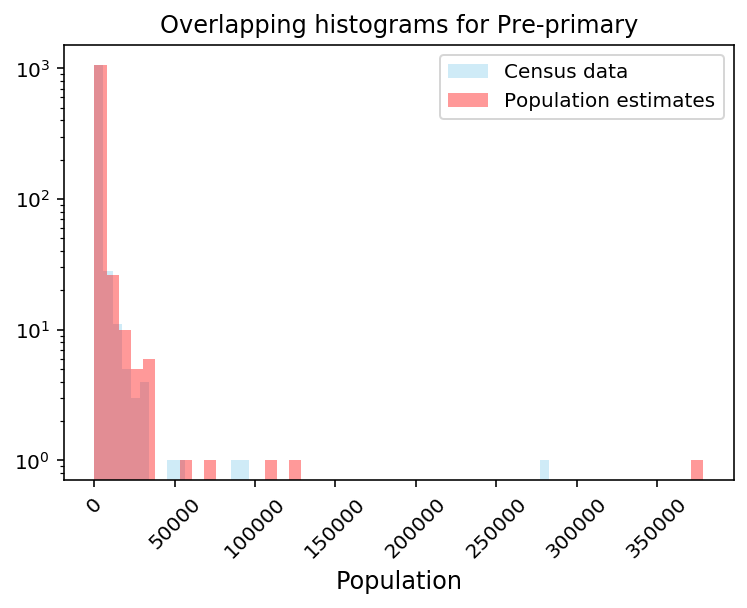

Primary


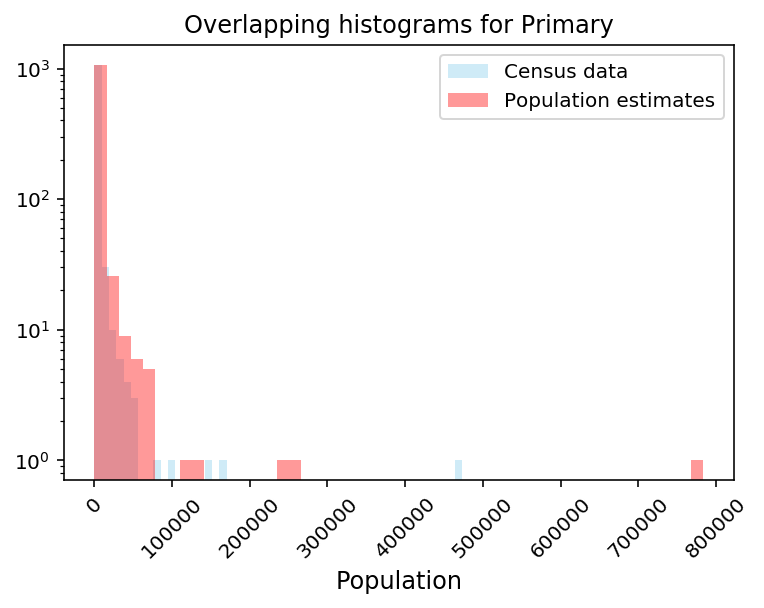

Lower secondary


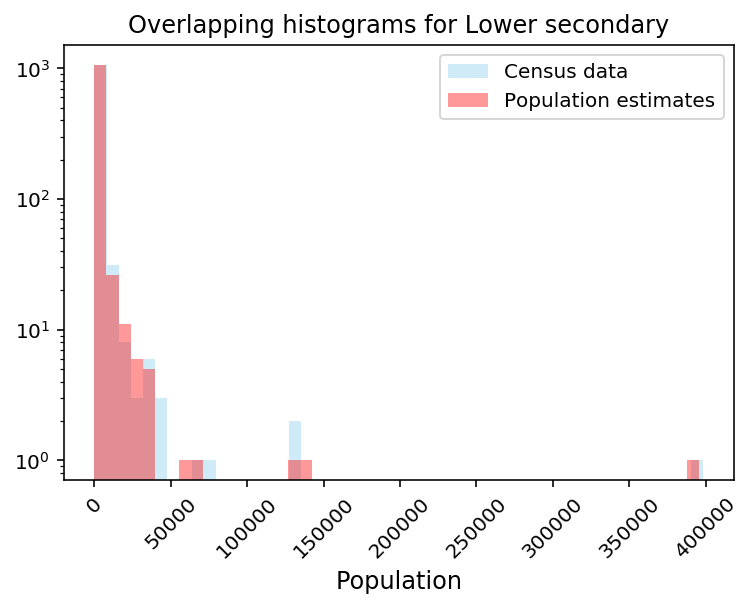

Upper secondary


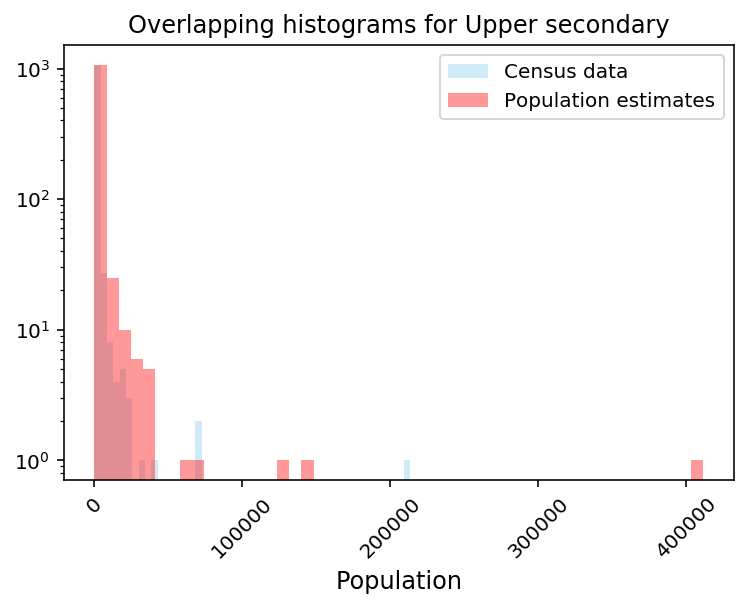

In [12]:
bars = ['Pre-primary', 'Primary', 'Lower secondary', 'Upper secondary']
for x in range(len(Levels)):
    print(bars[x])
    sns.distplot( MergedData["CD_"+Levels[x]] , color="skyblue", label="Census data", hist=True, kde=False, rug=False)
    sns.distplot( MergedData["PE_"+Levels[x]] , color="red", label="Population estimates", hist=True, kde=False, rug=False)
    plt.xlabel('Population', color = 'black', fontsize='12')
    plt.title("Overlapping histograms for " + bars[x])
    plt.legend()
    plt.xticks(color='black', rotation=45)
    plt.yscale('log')
    plt.show()


We then plot to see if the difference between the estimates and the actual data is related to the area of the polygon. While we see that there seems to be some relation, it is also clear that this behavior is also related to densely populated areas. This will be tested further down.

Pre-primary


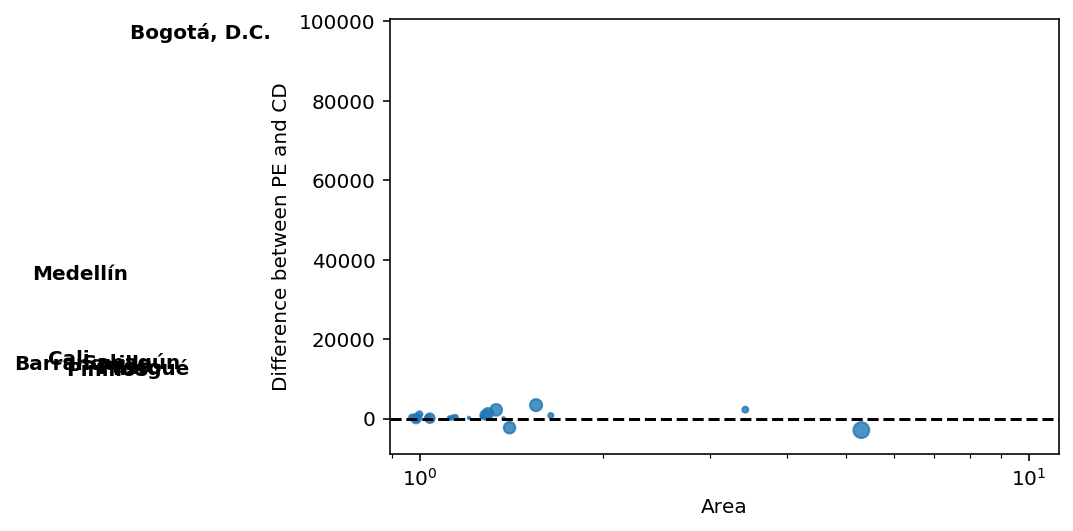

Primary


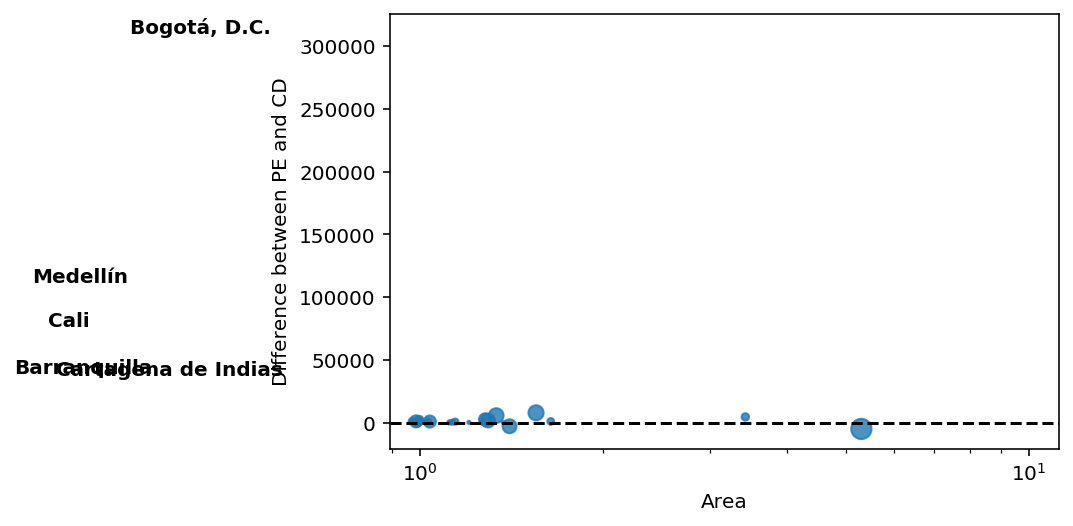

Lower secondary


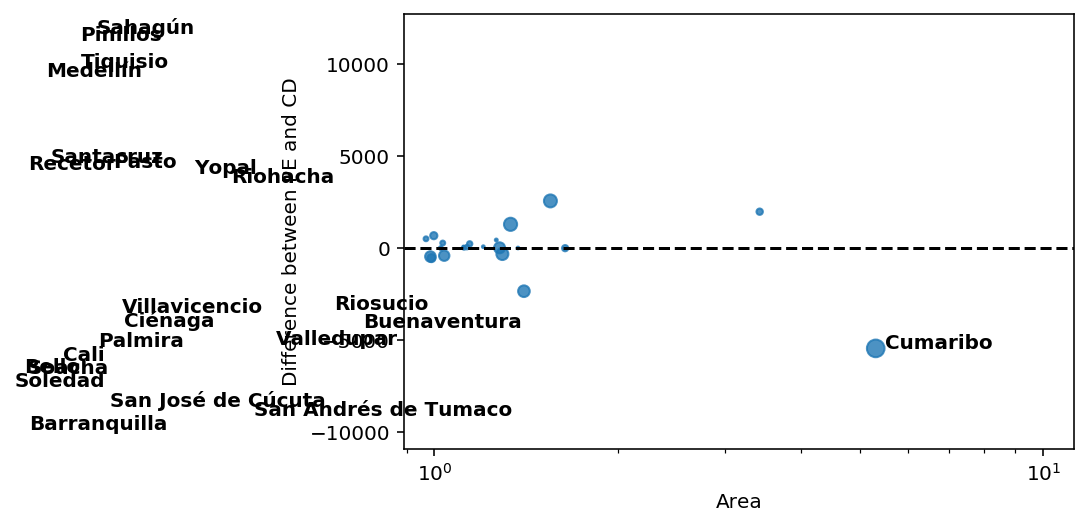

Upper secondary


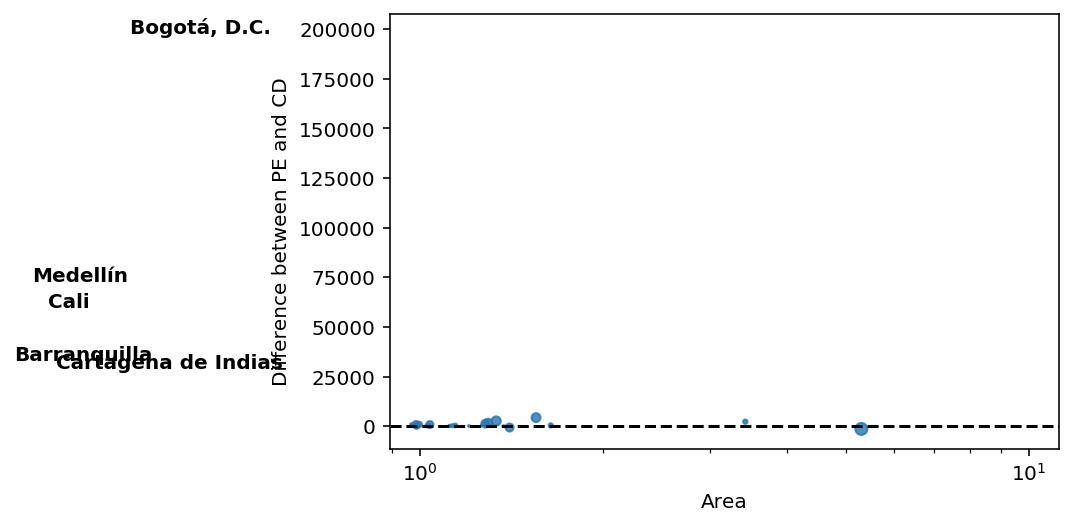

In [13]:
for x in range(len(Levels)):
    MergedData['Label_'+Levels[x]] = np.where(MergedData['Dif_'+Levels[x]]>=MergedData['Dif_'+Levels[x]].mean()+3*MergedData['Dif_'+Levels[x]].std(), MergedData['MunName'],
                                              np.where(MergedData['Dif_'+Levels[x]]<=-MergedData['Dif_'+Levels[x]].mean()-3*MergedData['Dif_'+Levels[x]].std(), MergedData['MunName'], ''))
    print(bars[x])
    p1 = sns.regplot(x=MergedData['Area'], y=MergedData['Dif_'+Levels[x]], scatter_kws={'s':MergedData['CD_'+Levels[x]]/100}, fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['Area'][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

If this methodology is to predict accurately the same information obtained from the Census, a regression fit between both series should yield a regression coefficient close to one.

In [14]:
Results = {}
for x in range(len(Levels)):
    formula = "PE_"+Levels[x]+"_std ~ CD_"+Levels[x]+"_std"
    result = sm.ols(formula=formula, data=MergedData).fit()
    heteroscedasticity_test = diag.het_breuschpagan(result.resid, result.model.exog)
    if heteroscedasticity_test[-1] <= 0.05:
        # The hypothesis that the error variance does not depend on x is rejected. There exists heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit(cov_type='HC0')
        print("Robust regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'Yes'}
    else:
        # The hypothesis that the error variance does not depend on x is kept. There is no heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit()
        print("Regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue[0][0]))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'No'}


Robust regression results for Pre-primary

                            OLS Regression Results                            
Dep. Variable:      PE_PrePrimary_std   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1785.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          1.46e-233
Time:                        13:28:21   Log-Likelihood:                 960.55
No. Observations:                1116   AIC:                            -1917.
Df Residuals:                    1114   BIC:                            -1907.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [15]:
Results = pd.DataFrame.from_dict(Results)
Results = Results.transpose()
Results['ConfidenceInterval'] = 1.98*Results['Std']
Results['Color'] = np.where(Results['Robust']=='Yes','lightblue','darkolivegreen')
Results = Results.transpose()
Results

,PrePrimary,Primary,LowSec,UppSec
Coefficient,0.994747,0.995317,0.996525,0.997295
Std,0.0235478,0.0213089,0.0110444,0.00925412
t_test,-0.223086,-0.219749,-0.314616,-0.292326
p_value,0.8234685231655551,0.8260669452544119,0.7530536020588268,0.7700375329381937
R_square,0.989521,0.990657,0.993063,0.994597
Robust,Yes,Yes,Yes,Yes
ConfidenceInterval,0.0466246,0.0421917,0.0218679,0.0183231
Color,lightblue,lightblue,lightblue,lightblue


We find that these coefficients are statistically equal to 1, with 99% of confidence.

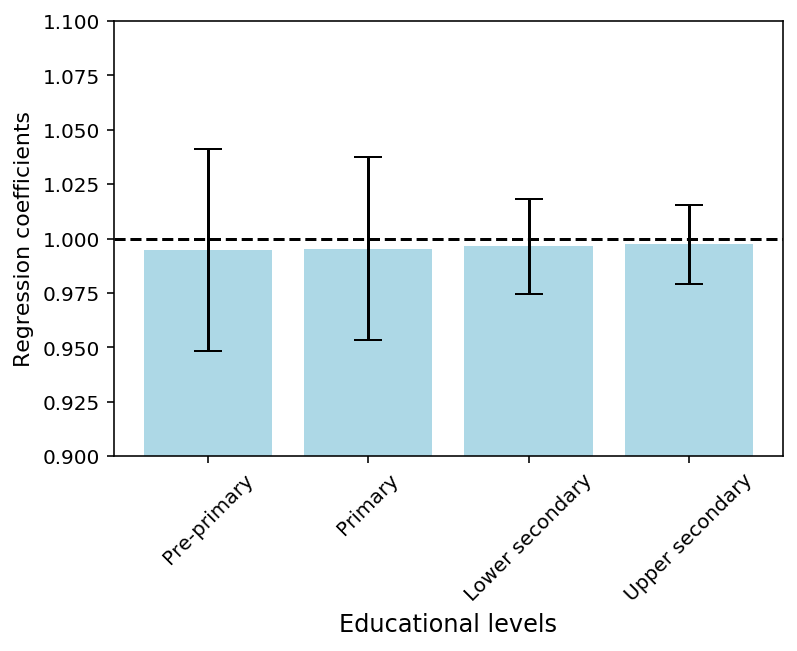

In [16]:
height = list(Results.loc['Coefficient'])
colors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
yer1 = list(Results.loc['ConfidenceInterval'])
plt.bar(y_pos, height, yerr=yer1, capsize=7, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('Regression coefficients', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.9,1.1)
plt.show()

Furthermore, as is to be expected of such a methodology, the regression fit, the R squared, is very close to 1, which indicated potential multicollineality (a positive trait in this case).

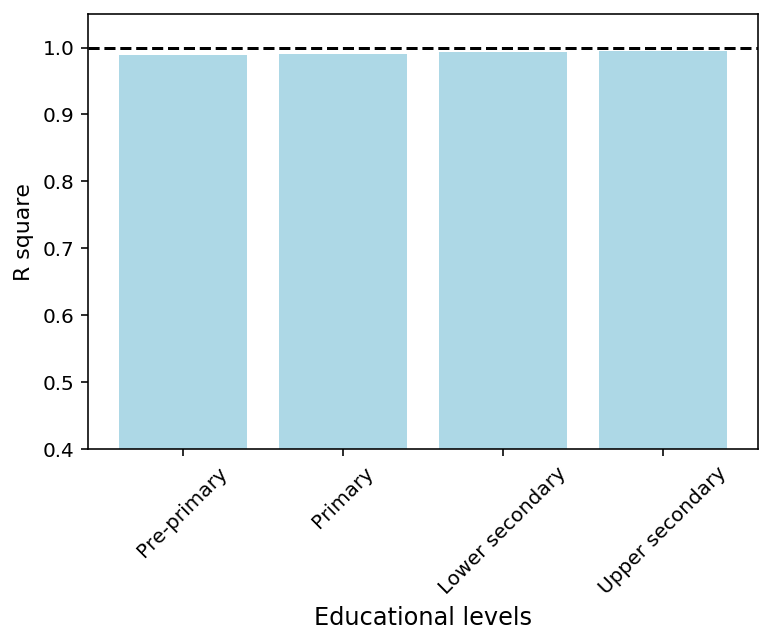

In [17]:
height = list(Results.loc['R_square'])
colors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('R square', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.4,1.05)
plt.show()

Testing for normality of the difference between both series shows there is not normality, although this is mainly because of considerable outliers (those highly populated areas seen before).

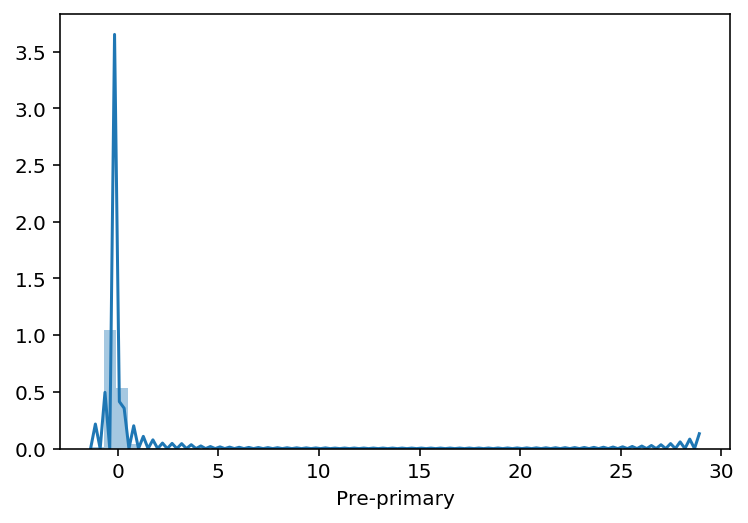

The difference between the Population estimates and the
Census data is not normally distributed for Pre-primary


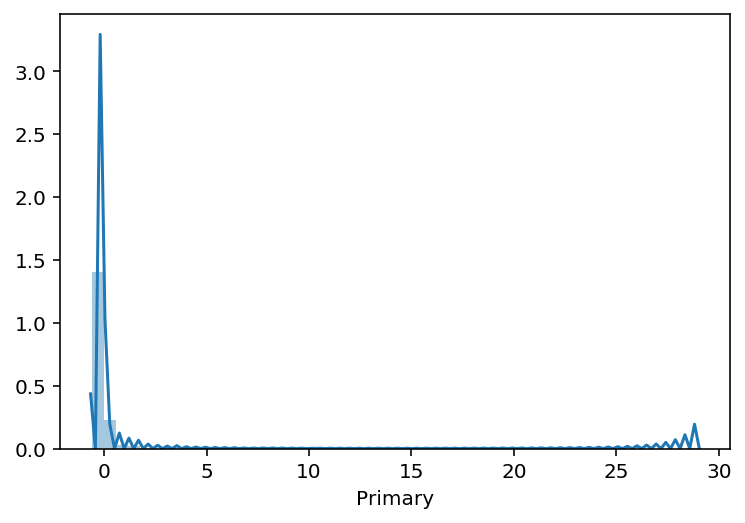

The difference between the Population estimates and the
Census data is not normally distributed for Primary


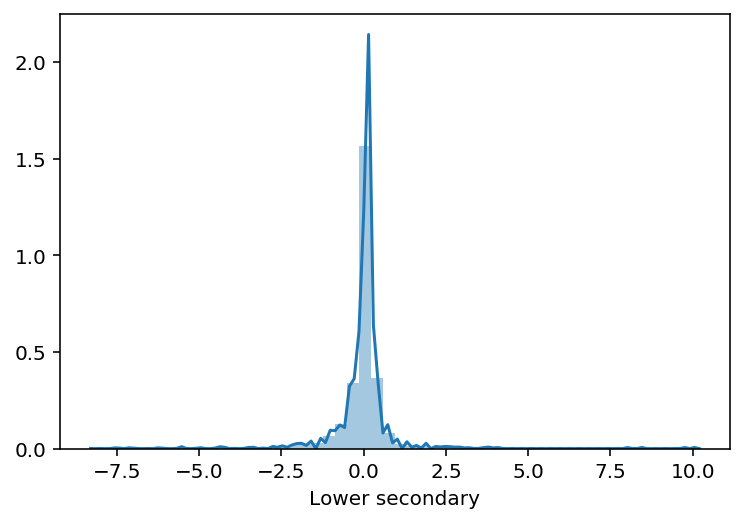

The difference between the Population estimates and the
Census data is not normally distributed for Lower secondary


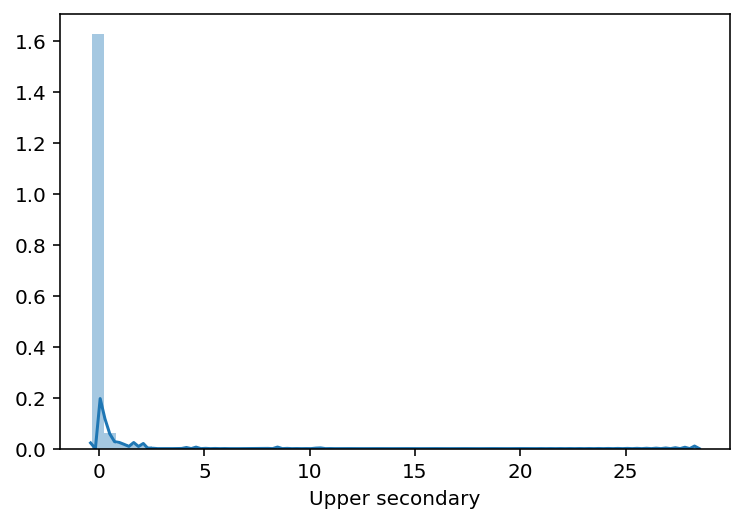

The difference between the Population estimates and the
Census data is not normally distributed for Upper secondary


In [18]:
for x in range(len(Levels)):
    sns.distplot( MergedData["Dif_"+Levels[x]+"_std"])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData["Dif_"+Levels[x]+"_std"])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Most of these outliers are eliminated once this is taken into account (by normalizing the difference between both series by the actual number of inhabitants).

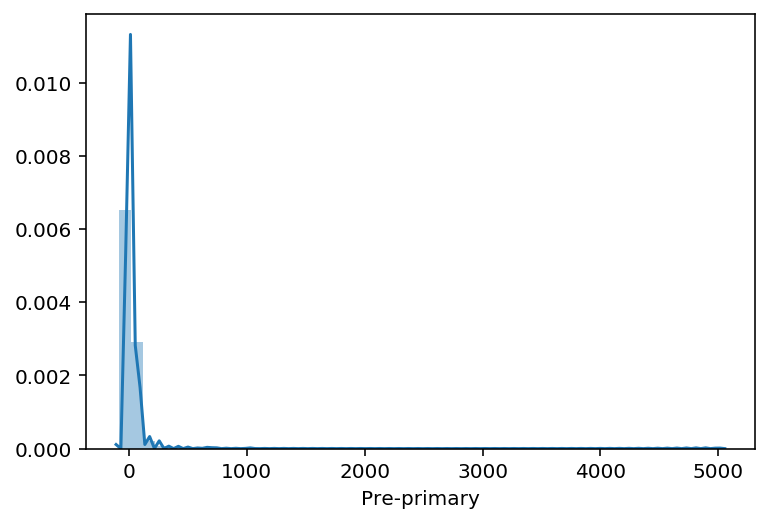

The difference between the Population estimates and the
Census data is not normally distributed for Pre-primary


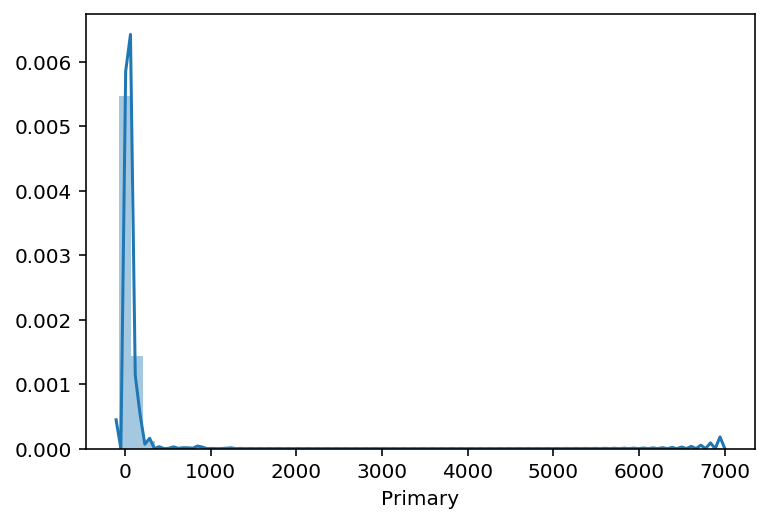

The difference between the Population estimates and the
Census data is not normally distributed for Primary


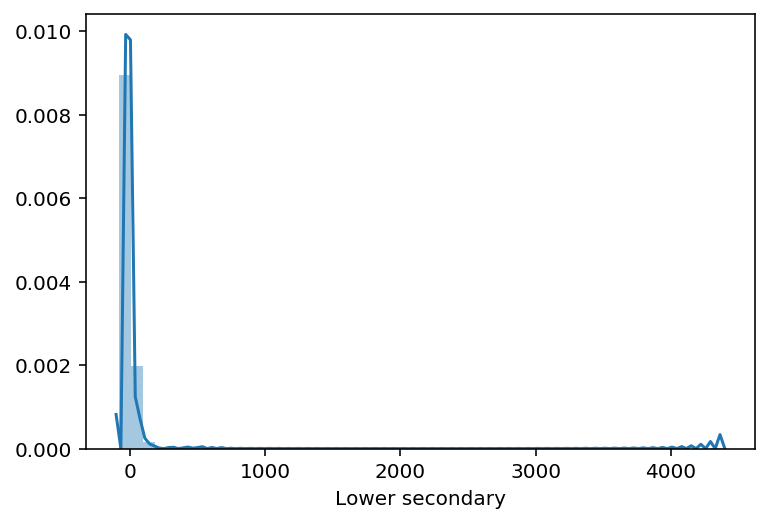

The difference between the Population estimates and the
Census data is not normally distributed for Lower secondary


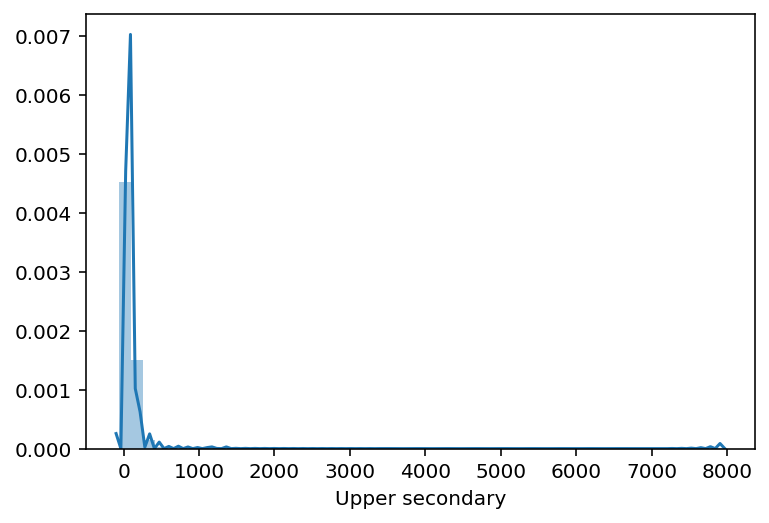

The difference between the Population estimates and the
Census data is not normally distributed for Upper secondary


In [19]:
for x in range(len(Levels)):
    MergedData['Perc_Dif_'+Levels[x]] = MergedData['Dif_'+Levels[x]]/MergedData['CD_'+Levels[x]]*100
    sns.distplot( MergedData['Perc_Dif_'+Levels[x]])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData['Perc_Dif_'+Levels[x]])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Finally, we see there is a high level of heteroscedasticity (as a function of the population size), with variance increasing with the number of people per administrative unit in the census...

Pre-primary


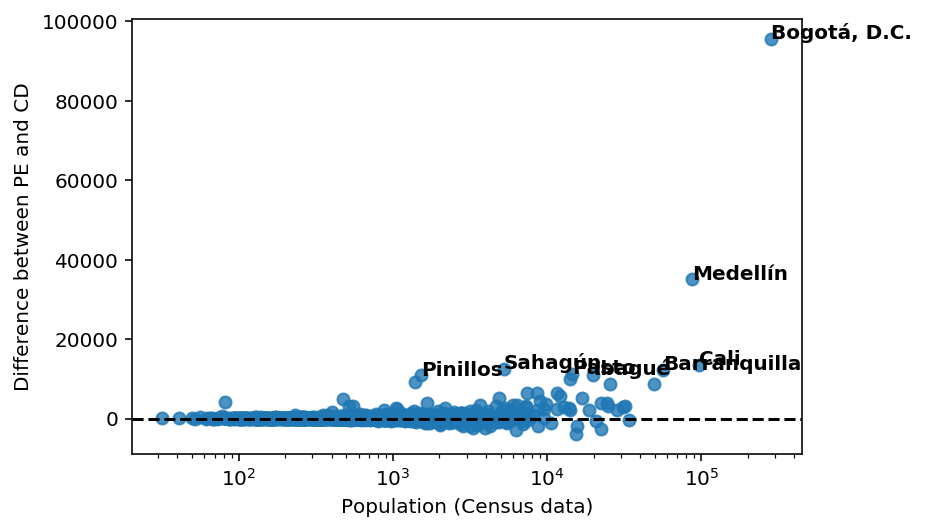

Primary


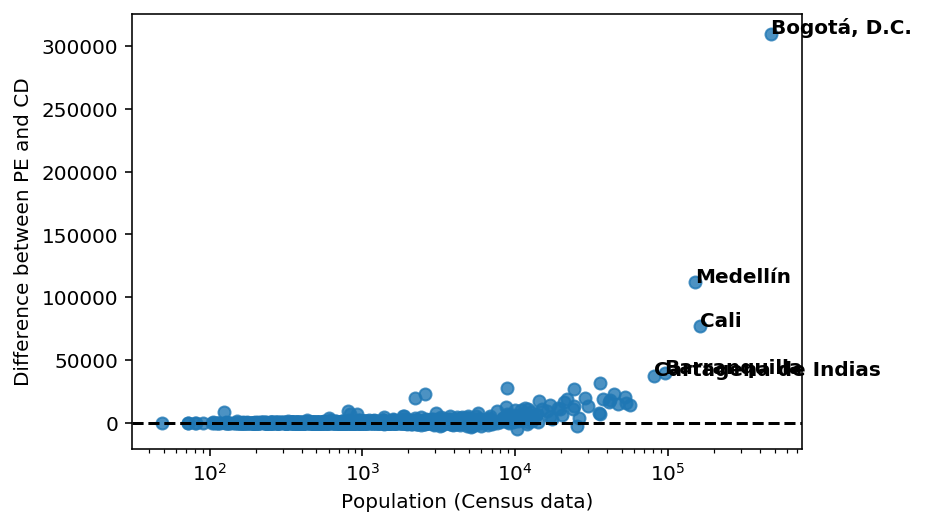

Lower secondary


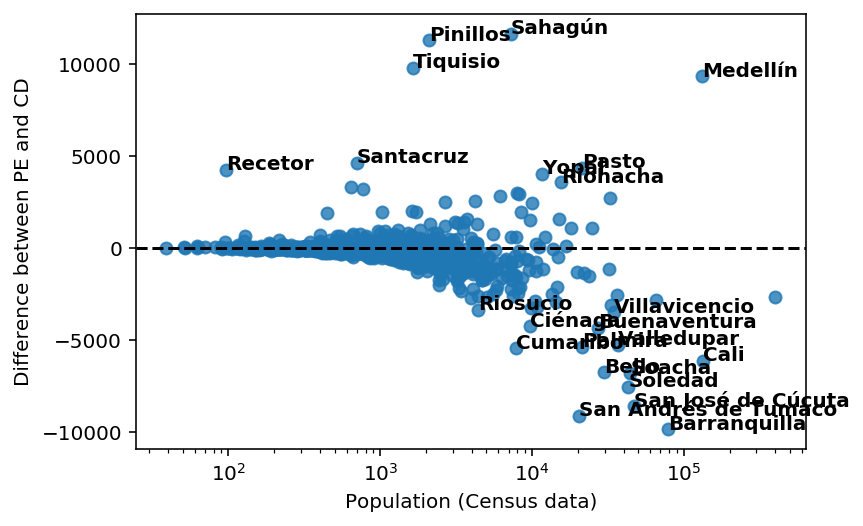

Upper secondary


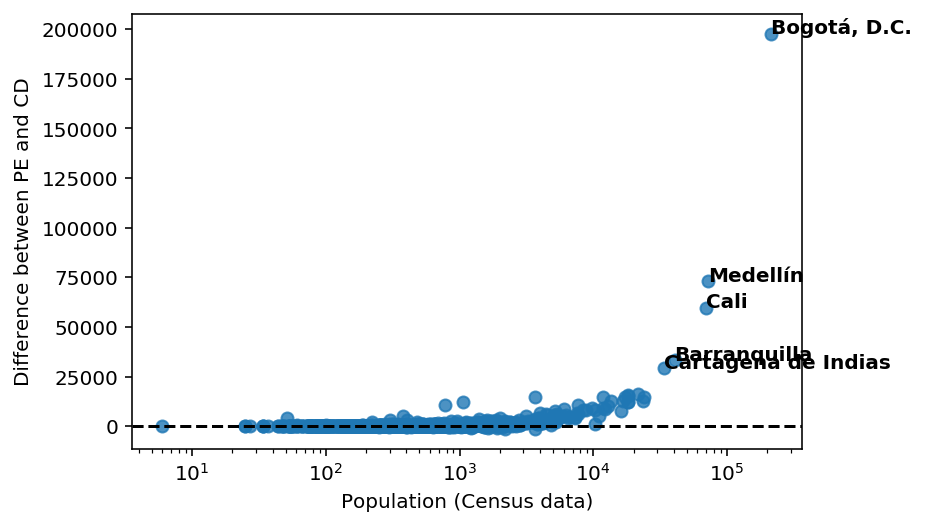

In [20]:
for x in range(len(Levels)):
    print(bars[x])
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Dif_'+Levels[x]], fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

... but such a behavior disappears once we use the percentage of the difference as a function of the total population, rather than the population as a whole.

Pre-primary


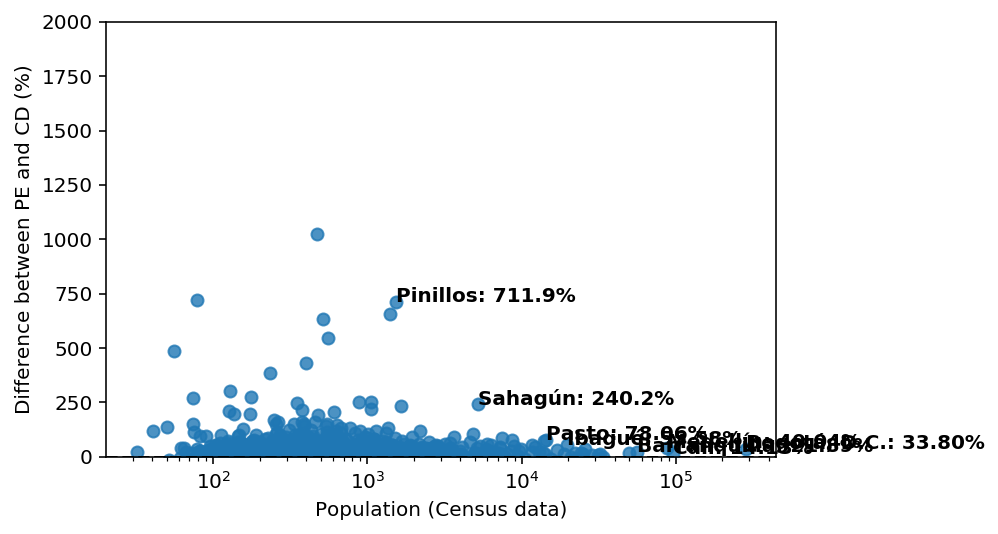

Primary


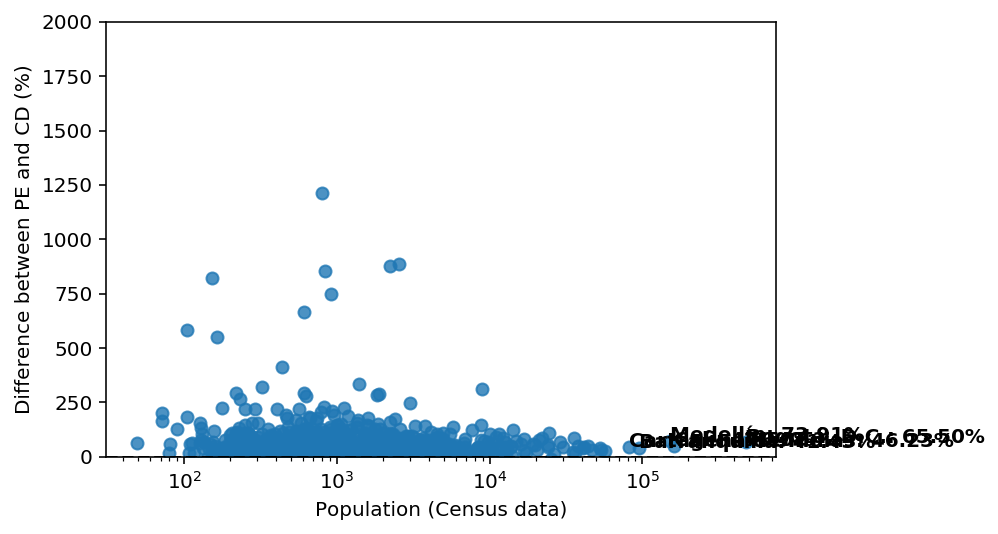

Lower secondary


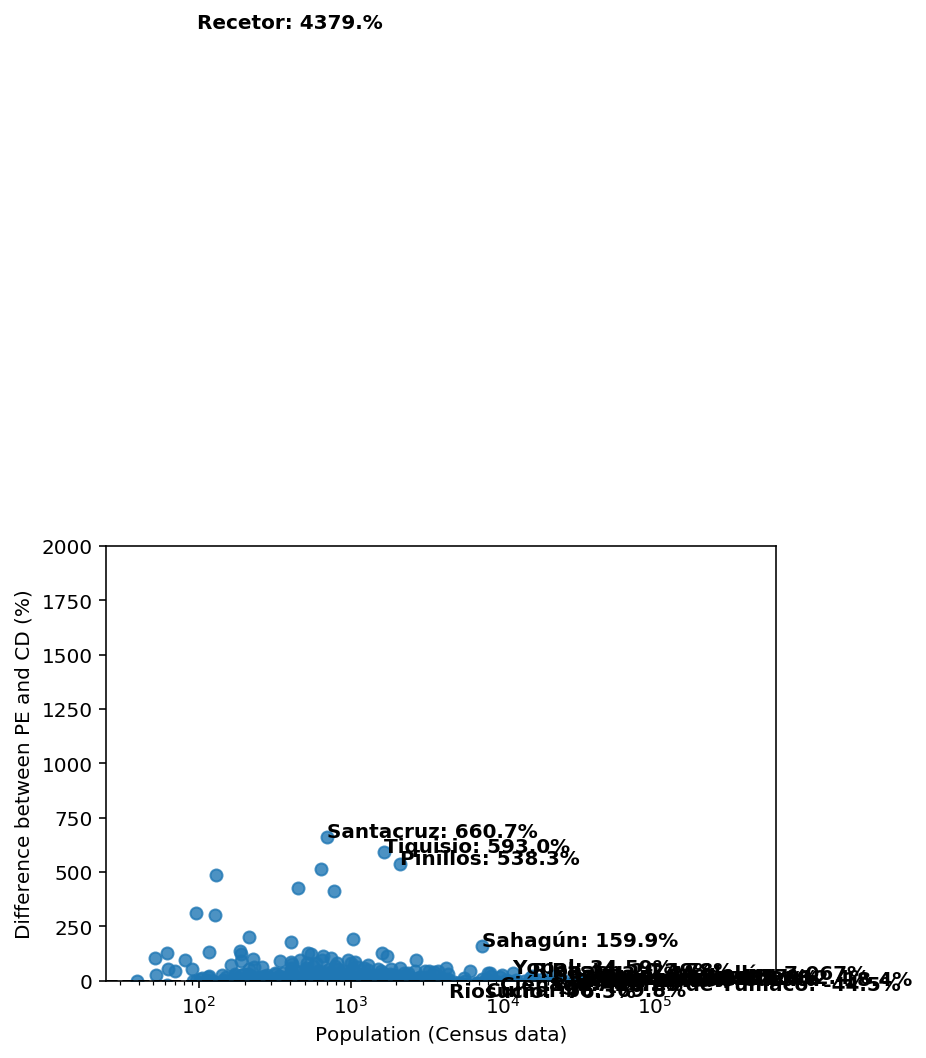

Upper secondary


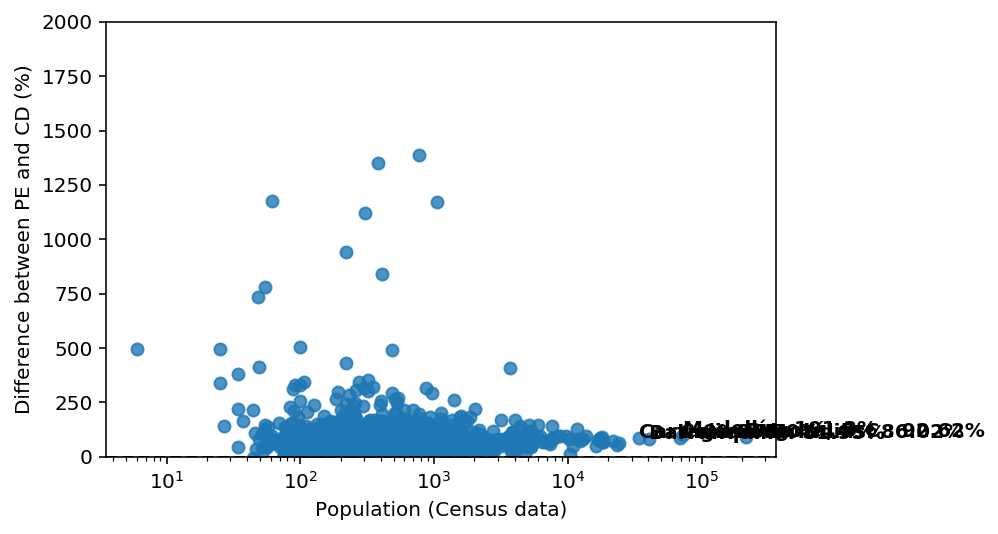

In [21]:
for x in range(len(Levels)):
    print(bars[x])
    MergedData['Perc_Dif_'+Levels[x]] = MergedData['Dif_'+Levels[x]]/MergedData['CD_'+Levels[x]]*100
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Perc_Dif_'+Levels[x]], fit_reg=False)
    for line in range(0,MergedData.shape[0]):
        if MergedData['Label_'+Levels[x]][line]!='':
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line]+': '+str(MergedData['Perc_Dif_'+Levels[x]][line])[:5]+'%', horizontalalignment='left', size='medium', color='black', weight='semibold')
        else:
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD (%)')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.ylim(0,2000)
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()